In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

In [2]:
df_1 = pd.read_csv('adj_close_prices.csv', parse_dates=['Date'])
df=df_1.copy()
# df
# Filter for dates from 2019 onwards
df = df[df['Date'] >= '2019-01-01']

# Set 'Date' as the index
df.set_index('Date', inplace=True)

# Sort index (optional but good practice)
df.sort_index(inplace=True)
etf_data=df.copy()

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Lookback period: 63 days
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long

Custom Combined Strategy Performance Metrics:
                      0
Total Return   0.842483
Annual Return  0.107745
Volatility     0.177051
Sharpe Ratio   0.608552
Max Drawdown  -0.319372


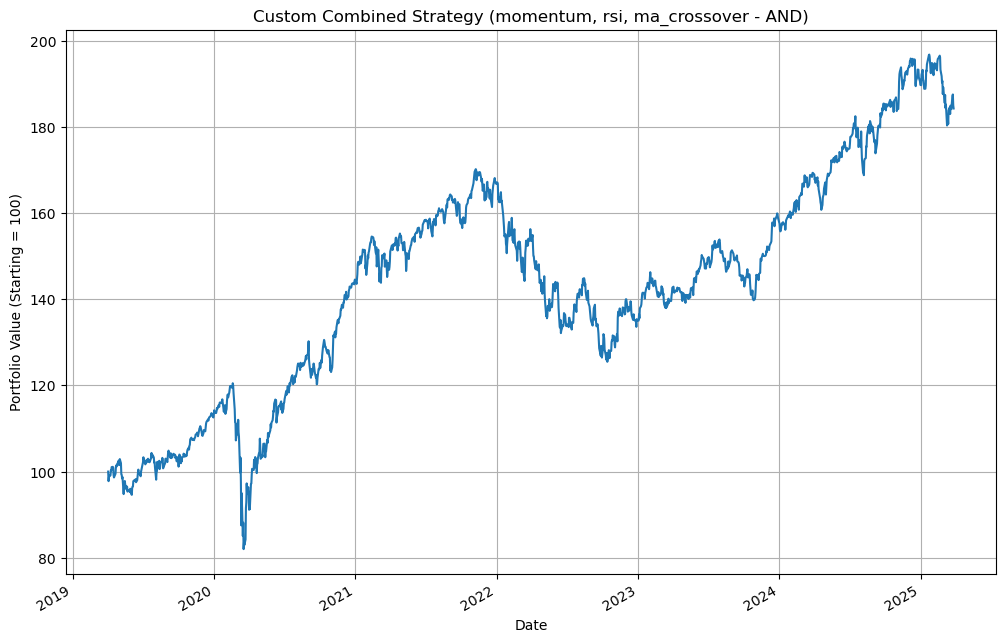

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


etf_data = df

# -------------------- STRATEGY INDICATOR FUNCTIONS --------------------

def calculate_momentum(data, lookback_period):
    """Calculate momentum as percentage price change over the lookback period"""
    return data.pct_change(lookback_period)

def calculate_rsi(data, window=14):
    """Calculate RSI for each ETF using vectorized operations"""
    delta = data.diff()
    # Use vectorized operations instead of where
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Avoid division by zero
    rs = avg_gain / avg_loss.replace(0, np.finfo(float).eps)
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_moving_average(data, window=50):
    """Calculate moving average for each ETF"""
    return data.rolling(window=window).mean()


def create_combined_strategy(data, 
                            strategy_types=['momentum'],  
                            lookback_period=252,         
                            rsi_window=14,               
                            ma_window=50,                
                            rebalance_period=21,         
                            num_stocks=10,               
                            portfolio_type='long_short', 
                            combine_method='and'):       
    """
    Create a trading strategy with customizable parameters that can combine multiple strategy types
    """
    # Validate inputs
    valid_strategies = {'momentum', 'rsi', 'ma_crossover'}
    valid_portfolio_types = {'long', 'short', 'long_short'}
    valid_combine_methods = {'and', 'or'}
    
    if not all(strategy in valid_strategies for strategy in strategy_types):
        raise ValueError(f"Invalid strategy type. Must be one of {valid_strategies}")
    
    if portfolio_type not in valid_portfolio_types:
        raise ValueError(f"portfolio_type must be one of {valid_portfolio_types}")
    
    if combine_method not in valid_combine_methods:
        raise ValueError(f"combine_method must be one of {valid_combine_methods}")
    
    # Precompute required indicators only once (optimization)
    indicators = {}
    if 'momentum' in strategy_types:
        indicators['momentum'] = calculate_momentum(data, lookback_period)
    if 'rsi' in strategy_types:
        indicators['rsi'] = calculate_rsi(data, window=rsi_window)
    if 'ma_crossover' in strategy_types:
        ma = calculate_moving_average(data, window=ma_window)
        indicators['ma_crossover'] = data / ma
    
    # Determine the minimum start index based on the strategies used
    min_start_idx = max([
        lookback_period if 'momentum' in strategy_types else 0,
        rsi_window if 'rsi' in strategy_types else 0,
        ma_window if 'ma_crossover' in strategy_types else 0
    ])
    
    # Determine rebalancing dates efficiently
    idx_range = pd.date_range(start=data.index[min_start_idx], end=data.index[-1], freq=f'{rebalance_period}D')
    rebalance_dates = data.index[data.index.searchsorted(idx_range)]
    rebalance_dates = rebalance_dates[rebalance_dates <= data.index[-1]]
    
    # Pre-initialize all dataframes with correct size
    portfolio_top = pd.Series(np.nan, index=data.index)
    portfolio_bottom = pd.Series(np.nan, index=data.index)
    portfolio_combined = pd.Series(np.nan, index=data.index)
    
    # Use boolean arrays for holdings (more memory efficient)
    portfolio_top_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    portfolio_bottom_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    
    # Initial portfolio values
    portfolio_value_top = 100.0
    portfolio_value_bottom = 100.0
    portfolio_value_combined = 100.0
    
    # Calculate daily returns once for the entire period
    daily_returns = data.pct_change().fillna(0)
    
    # Process each rebalance period
    for i, rebalance_date in enumerate(rebalance_dates):
        # Get the index position of the rebalance date
        idx = data.index.get_loc(rebalance_date)
        
        # Precompute all rankings at once for efficiency
        rankings = {}
        for strategy in strategy_types:
            indicator_values = indicators[strategy].iloc[idx]
            
            # Optimize ranking calculations
            if strategy == 'momentum':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
            elif strategy == 'rsi':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=True)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=False)
            elif strategy == 'ma_crossover':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
        
        # Combine rankings efficiently
        if len(strategy_types) > 1:
            if combine_method == 'and':
                # Sum ranks using numpy for speed
                combined_top_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
            else:  # 'or'
                # Use numpy min for speed
                combined_top_rank = pd.Series(
                    np.min([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.min([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
        else:
            # Single strategy case
            combined_top_rank = rankings[f'{strategy_types[0]}_top']
            combined_bottom_rank = rankings[f'{strategy_types[0]}_bottom']
        
        # Select top and bottom performers
        top_assets = combined_top_rank.nsmallest(num_stocks).index
        bottom_assets = combined_bottom_rank.nsmallest(num_stocks).index
        
        # Update holdings efficiently using loc and boolean arrays
        portfolio_top_holdings.loc[rebalance_date, top_assets] = True
        portfolio_bottom_holdings.loc[rebalance_date, bottom_assets] = True
        
        # Find the period dates
        next_rebalance_idx = i + 1
        next_rebalance_date = rebalance_dates[next_rebalance_idx] if next_rebalance_idx < len(rebalance_dates) else data.index[-1]
        period_mask = (data.index >= rebalance_date) & (data.index <= next_rebalance_date)
        period_dates = data.index[period_mask]
        
        # Record initial portfolio values
        portfolio_top.loc[rebalance_date] = portfolio_value_top
        portfolio_bottom.loc[rebalance_date] = portfolio_value_bottom
        portfolio_combined.loc[rebalance_date] = portfolio_value_combined
        
        # Current holdings as boolean masks
        current_top = portfolio_top_holdings.loc[rebalance_date]
        current_bottom = portfolio_bottom_holdings.loc[rebalance_date]
        
        # Process each day efficiently
        for date in period_dates[1:]:  # Skip rebalance date which we've already processed
            # Calculate portfolio returns (vectorized)
            top_returns = daily_returns.loc[date, current_top]
            bottom_returns = daily_returns.loc[date, current_bottom]
            
            port_return_top = top_returns.mean() if current_top.any() else 0
            port_return_bottom = -bottom_returns.mean() if current_bottom.any() else 0
            
            # Update portfolio values
            portfolio_value_top *= (1 + port_return_top)
            portfolio_value_bottom *= (1 + port_return_bottom)
            
            # Calculate combined portfolio value
            if portfolio_type == 'long_short':
                port_return_combined = 0.5 * port_return_top + 0.5 * port_return_bottom
                portfolio_value_combined *= (1 + port_return_combined)
            
            # Record portfolio values
            portfolio_top.loc[date] = portfolio_value_top
            portfolio_bottom.loc[date] = portfolio_value_bottom
            portfolio_combined.loc[date] = portfolio_value_combined
            
            # Copy holdings forward (efficient)
            portfolio_top_holdings.loc[date] = current_top
            portfolio_bottom_holdings.loc[date] = current_bottom
    
    # Create final portfolio based on type - no need to copy data again
    if portfolio_type == 'long':
        final_portfolio = portfolio_top
        final_holdings = portfolio_top_holdings
    elif portfolio_type == 'short':
        final_portfolio = portfolio_bottom
        final_holdings = portfolio_bottom_holdings
    else:  # long_short
        final_portfolio = portfolio_combined
        
        # Create combined holdings efficiently
        final_holdings = pd.DataFrame(0, index=data.index, columns=data.columns)
        long_mask = portfolio_top_holdings
        short_mask = portfolio_bottom_holdings
        
        # Use vectorized operations
        final_holdings[long_mask] = 1
        final_holdings[short_mask] = -1
    
    return {
        'portfolio_values': final_portfolio,
        'holdings': final_holdings,
        'portfolio_top': portfolio_top,
        'portfolio_bottom': portfolio_bottom,
        'portfolio_combined': portfolio_combined,
        'top_holdings': portfolio_top_holdings,
        'bottom_holdings': portfolio_bottom_holdings,
        'strategies_used': strategy_types,
        'combine_method': combine_method
    }


def calculate_performance_metrics(portfolio_values):
    """Calculate performance metrics for a portfolio with vectorized operations"""
    # Drop NaN values once
    clean_values = portfolio_values.dropna()
    
    # Return early if insufficient data
    if len(clean_values) < 2:
        return {
            'Total Return': np.nan,
            'Annual Return': np.nan,
            'Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan
        }
    
    # Calculate metrics in one go
    daily_returns = clean_values.pct_change().iloc[1:]  # Skip first day
    total_return = (clean_values.iloc[-1] / clean_values.iloc[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(clean_values)) - 1
    volatility = daily_returns.std() * np.sqrt(252)
    
    # Avoid division by zero
    sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    
    # Calculate drawdown vector in one step
    drawdown = clean_values / clean_values.cummax() - 1
    max_drawdown = drawdown.min()
    
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown
    }


def plot_strategy_performance(strategies_dict, title="Strategy Performance"):
    """Plot the performance of multiple strategies with optimized plotting"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Normalize all series at once for efficiency
    normalized_data = pd.DataFrame({
        name: 100 * portfolio / portfolio.iloc[0] 
        for name, portfolio in strategies_dict.items()
    })
    
    # Plot all series in one go
    normalized_data.plot(ax=ax, grid=True)
    
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value (Starting = 100)')
    
    return plt


# -------------------- CUSTOM COMBINED STRATEGY FUNCTION --------------------

def create_custom_combined_strategy(data, 
                                   strategy_types=['momentum', 'rsi'],
                                   lookback_period=252,
                                   rsi_window=14,
                                   ma_window=50,
                                   rebalance_period=21,
                                   num_stocks=10,
                                   portfolio_type='long_short',
                                   combine_method='and'):
    """
    Create a custom combined strategy with user-specified parameters
    
    Returns the strategy results and performance metrics
    """
    print(f"Creating custom combined strategy with parameters:")
    print(f"  - Strategies used: {strategy_types}")
    print(f"  - Combination method: {combine_method}")
    print(f"  - Lookback period: {lookback_period} days")
    print(f"  - RSI window: {rsi_window} days")
    print(f"  - MA window: {ma_window} days")
    print(f"  - Rebalance period: {rebalance_period} days")
    print(f"  - Number of stocks: {num_stocks}")
    print(f"  - Portfolio type: {portfolio_type}")
    
    # Create the strategy
    result = create_combined_strategy(
        data,
        strategy_types=strategy_types,
        lookback_period=lookback_period,
        rsi_window=rsi_window,
        ma_window=ma_window,
        rebalance_period=rebalance_period,
        num_stocks=num_stocks,
        portfolio_type=portfolio_type,
        combine_method=combine_method
    )
    
    # Calculate performance metrics
    portfolio_values = result['portfolio_values'].dropna()
    metrics = calculate_performance_metrics(portfolio_values)
    
    # Plot the performance (more efficient way)
    fig, ax = plt.subplots(figsize=(12, 8))
    normalized = 100 * portfolio_values / portfolio_values.iloc[0]
    normalized.plot(ax=ax, grid=True)
    ax.set_title(f"Custom Combined Strategy ({', '.join(strategy_types)} - {combine_method.upper()})")
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value (Starting = 100)')
    
    return {
        'result': result,
        'metrics': metrics,
        'plot': plt
    }


# Example of using the custom combined strategy function
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum', 'rsi', 'ma_crossover'],
    lookback_period=63,
    rsi_window=10,
    ma_window=20,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='and'
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
custom_combined['plot'].savefig('custom_combined_strategy.png')

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Lookback period: 63 days
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 30 days
  - Number of stocks: 5
  - Portfolio type: long_short

Custom Combined Strategy Performance Metrics:
                      0
Total Return   0.360642
Annual Return  0.052917
Volatility     0.070810
Sharpe Ratio   0.747311
Max Drawdown  -0.135994


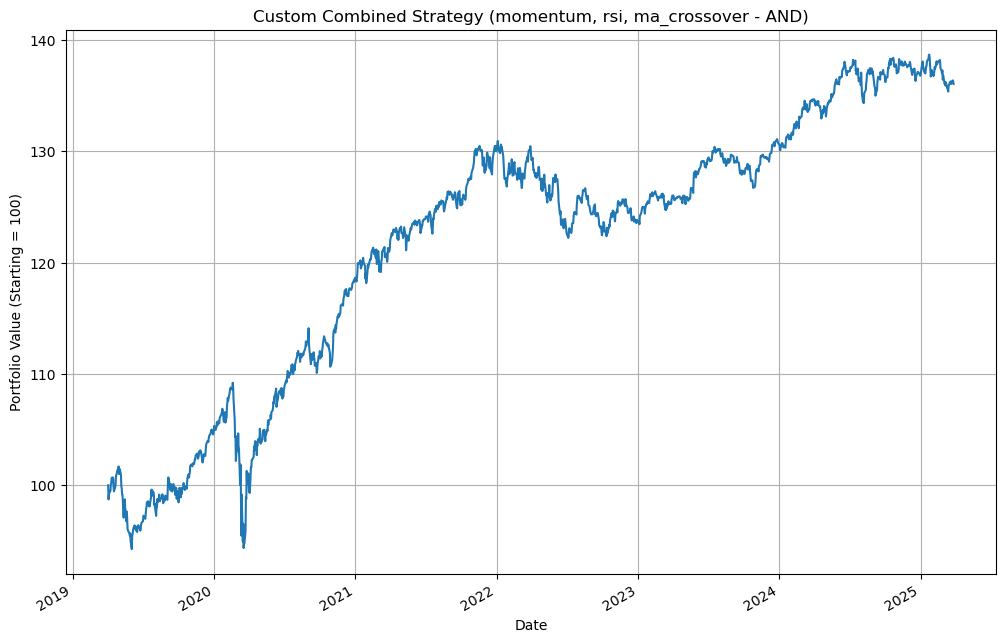

In [5]:
custom_combined = create_custom_combined_strategy(
    etf_data,
    strategy_types=['momentum', 'rsi', 'ma_crossover'],  # Use all three strategies
    lookback_period=63,                                  # ~3 months for momentum
    rsi_window=10,                                       # 10-day RSI
    ma_window=20,                                        # 20-day MA
    rebalance_period=30,                                 # 10-day rebalancing
    num_stocks=5,                                        # Select top/bottom 5 stocks
    portfolio_type='long_short',                               # Long-only portfolio
    combine_method='and'                                 # Require agreement across strategies
)

print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)
custom_combined['plot'].savefig('custom_combined_strategy.png')

Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Base lookback period: 63 days
  - Using dynamic VIX-based lookback period
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long
  - Benchmark: ^GSPC
  - Dynamic lookback range: 40 to 124 days

Dynamic VIX-based Strategy Performance Metrics:
                          0
Total Return       0.709221
Annual Return      0.093906
Volatility         0.142760
Sharpe Ratio       0.657791
Max Drawdown      -0.238739
Information Ratio  0.349745
Beta               1.103193
Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Base lookback period: 63 days
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long
  - Benchmark: ^GSPC


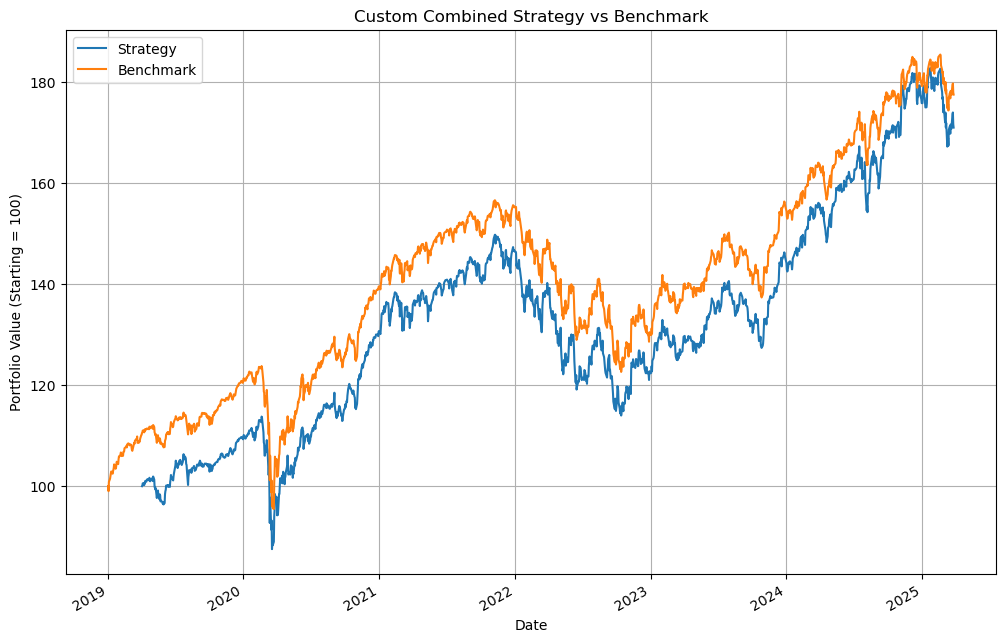

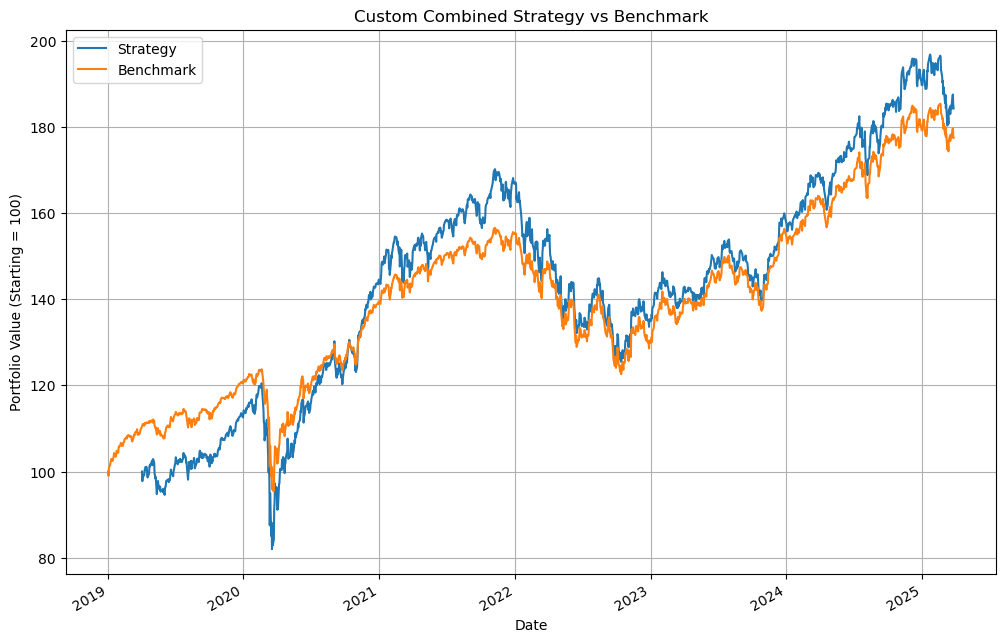

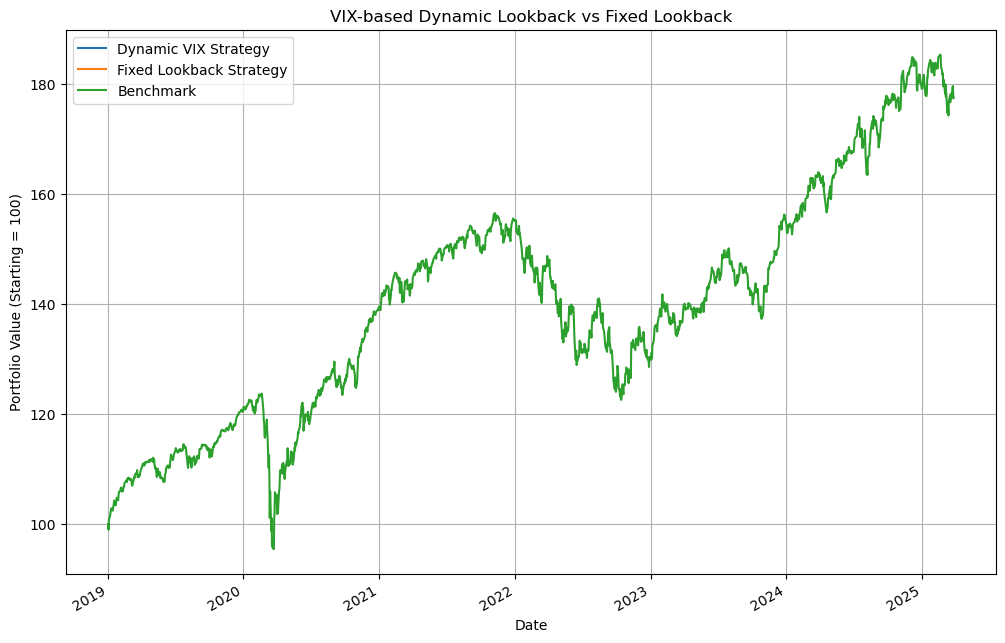

In [7]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


etf_data = df  # Assuming df is already defined elsewhere

# -------------------- BENCHMARK FUNCTION --------------------

def create_benchmark(data, benchmark_ticker='^GSPC'):
    """
    Create a benchmark portfolio based on a specified ticker
    If the benchmark ticker is in the data, use it directly
    Otherwise, assume it's an equal-weighted portfolio of all assets
    
    Parameters:
    -----------
    data : DataFrame
        Price data for all ETFs
    benchmark_ticker : str
        Ticker symbol for the benchmark (default: S&P 500)
        
    Returns:
    --------
    Series with benchmark performance values
    """
    if benchmark_ticker in data.columns:
        # Use the specified ticker as benchmark
        benchmark_values = data[benchmark_ticker].copy()
        # Normalize to 100
        benchmark_values = 100 * benchmark_values / benchmark_values.iloc[0]
    else:
        # Create an equal-weighted portfolio as benchmark
        benchmark_returns = data.pct_change().mean(axis=1)
        benchmark_values = (1 + benchmark_returns).cumprod() * 100
        benchmark_values.iloc[0] = 100  # Set initial value to 100
    
    return benchmark_values

# -------------------- VIX-BASED DYNAMIC LOOKBACK PERIOD --------------------

def calculate_dynamic_lookback(vix_data, base_lookback=252, vix_min=10, vix_max=40):
    """
    Calculate a dynamic lookback period based on VIX levels
    
    Higher VIX (more market fear) = shorter lookback period
    Lower VIX (less market fear) = longer lookback period
    
    Parameters:
    -----------
    vix_data : Series
        VIX data time series
    base_lookback : int
        Base lookback period when VIX is at median level
    vix_min : float
        Minimum VIX level (will result in longest lookback)
    vix_max : float
        Maximum VIX level (will result in shortest lookback)
    
    Returns:
    --------
    Series with dynamic lookback periods for each date
    """
    # Ensure we have VIX data
    if vix_data is None or len(vix_data) == 0:
        # No VIX data, return constant lookback period
        return pd.Series(base_lookback, index=vix_data.index)
    
    # Get latest VIX value for each trading day
    vix_daily = vix_data.resample('D').last().fillna(method='ffill')
    
    # Calculate exponentially weighted moving average of VIX for smoother transitions
    vix_ewma = vix_daily.ewm(span=20).mean()
    
    # Clip VIX values to min/max range
    vix_clipped = np.clip(vix_ewma, vix_min, vix_max)
    
    # Invert and scale the relationship:
    # High VIX = shorter lookback (min 30 days)
    # Low VIX = longer lookback (max 2x base_lookback)
    
    # Normalize VIX to 0-1 range
    vix_normalized = (vix_clipped - vix_min) / (vix_max - vix_min)
    
    # Calculate dynamic lookback (inverted relationship with VIX)
    # When VIX is high (vix_normalized near 1), lookback approaches min_lookback
    # When VIX is low (vix_normalized near 0), lookback approaches max_lookback
    min_lookback = 21  # Minimum lookback period (days)
    max_lookback = base_lookback * 2  # Maximum lookback period (days)
    
    dynamic_lookback = min_lookback + (1 - vix_normalized) * (max_lookback - min_lookback)
    
    # Round to nearest integer
    dynamic_lookback = dynamic_lookback.round().astype(int)
    
    return dynamic_lookback

# -------------------- STRATEGY INDICATOR FUNCTIONS --------------------

def calculate_momentum(data, lookback_period):
    """Calculate momentum as percentage price change over the lookback period"""
    return data.pct_change(lookback_period)

def calculate_rsi(data, window=14):
    """Calculate RSI for each ETF using vectorized operations"""
    delta = data.diff()
    # Use vectorized operations instead of where
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Avoid division by zero
    rs = avg_gain / avg_loss.replace(0, np.finfo(float).eps)
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_moving_average(data, window=50):
    """Calculate moving average for each ETF"""
    return data.rolling(window=window).mean()


def create_combined_strategy(data, 
                            strategy_types=['momentum'],  
                            lookback_period=252,         
                            dynamic_lookback=None,      # New parameter for dynamic lookback
                            rsi_window=14,               
                            ma_window=50,                
                            rebalance_period=21,         
                            num_stocks=10,               
                            portfolio_type='long_short', 
                            combine_method='and'):       
    """
    Create a trading strategy with customizable parameters that can combine multiple strategy types
    """
    # Validate inputs
    valid_strategies = {'momentum', 'rsi', 'ma_crossover'}
    valid_portfolio_types = {'long', 'short', 'long_short'}
    valid_combine_methods = {'and', 'or'}
    
    if not all(strategy in valid_strategies for strategy in strategy_types):
        raise ValueError(f"Invalid strategy type. Must be one of {valid_strategies}")
    
    if portfolio_type not in valid_portfolio_types:
        raise ValueError(f"portfolio_type must be one of {valid_portfolio_types}")
    
    if combine_method not in valid_combine_methods:
        raise ValueError(f"combine_method must be one of {valid_combine_methods}")
    
    # Determine the minimum start index based on the strategies used
    min_start_idx = max([
        lookback_period if 'momentum' in strategy_types else 0,
        rsi_window if 'rsi' in strategy_types else 0,
        ma_window if 'ma_crossover' in strategy_types else 0
    ])
    
    # Determine rebalancing dates efficiently
    idx_range = pd.date_range(start=data.index[min_start_idx], end=data.index[-1], freq=f'{rebalance_period}D')
    rebalance_dates = data.index[data.index.searchsorted(idx_range)]
    rebalance_dates = rebalance_dates[rebalance_dates <= data.index[-1]]
    
    # Pre-initialize all dataframes with correct size
    portfolio_top = pd.Series(np.nan, index=data.index)
    portfolio_bottom = pd.Series(np.nan, index=data.index)
    portfolio_combined = pd.Series(np.nan, index=data.index)
    
    # Use boolean arrays for holdings (more memory efficient)
    portfolio_top_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    portfolio_bottom_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    
    # Initial portfolio values
    portfolio_value_top = 100.0
    portfolio_value_bottom = 100.0
    portfolio_value_combined = 100.0
    
    # Calculate daily returns once for the entire period
    daily_returns = data.pct_change().fillna(0)
    
    # Precompute indicators that don't depend on dynamic lookback
    indicators = {}
    if 'rsi' in strategy_types:
        indicators['rsi'] = calculate_rsi(data, window=rsi_window)
    if 'ma_crossover' in strategy_types:
        ma = calculate_moving_average(data, window=ma_window)
        indicators['ma_crossover'] = data / ma
    
    # Process each rebalance period
    for i, rebalance_date in enumerate(rebalance_dates):
        # Get the index position of the rebalance date
        idx = data.index.get_loc(rebalance_date)
        
        # If using dynamic lookback, get the specific lookback period for this date
        actual_lookback = lookback_period
        if dynamic_lookback is not None and 'momentum' in strategy_types:
            # Find the closest date in dynamic_lookback
            closest_date = dynamic_lookback.index[dynamic_lookback.index.get_indexer([rebalance_date], method='nearest')[0]]
            actual_lookback = dynamic_lookback.loc[closest_date]
            # Calculate momentum with dynamic lookback specifically for this rebalance date
            momentum_values = calculate_momentum(data.iloc[:idx+1], actual_lookback).iloc[idx]
            indicators['momentum'] = momentum_values 
        elif 'momentum' in strategy_types and 'momentum' not in indicators:
            # Calculate momentum with fixed lookback if not done yet
            indicators['momentum'] = calculate_momentum(data, lookback_period)
        
        # Precompute all rankings at once for efficiency
        rankings = {}
        for strategy in strategy_types:
            # For momentum, we may need to handle it differently if using dynamic lookback
            if strategy == 'momentum' and dynamic_lookback is not None:
                # We've already calculated this above
                indicator_values = indicators['momentum']
            else:
                indicator_values = indicators[strategy].iloc[idx]
            
            # Optimize ranking calculations
            if strategy == 'momentum':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
            elif strategy == 'rsi':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=True)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=False)
            elif strategy == 'ma_crossover':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
        
        # Combine rankings efficiently
        if len(strategy_types) > 1:
            if combine_method == 'and':
                # Sum ranks using numpy for speed
                combined_top_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
            else:  # 'or'
                # Use numpy min for speed
                combined_top_rank = pd.Series(
                    np.min([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.min([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
        else:
            # Single strategy case
            combined_top_rank = rankings[f'{strategy_types[0]}_top']
            combined_bottom_rank = rankings[f'{strategy_types[0]}_bottom']
        
        # Select top and bottom performers
        top_assets = combined_top_rank.nsmallest(num_stocks).index
        bottom_assets = combined_bottom_rank.nsmallest(num_stocks).index
        
        # Update holdings efficiently using loc and boolean arrays
        portfolio_top_holdings.loc[rebalance_date, top_assets] = True
        portfolio_bottom_holdings.loc[rebalance_date, bottom_assets] = True
        
        # Find the period dates
        next_rebalance_idx = i + 1
        next_rebalance_date = rebalance_dates[next_rebalance_idx] if next_rebalance_idx < len(rebalance_dates) else data.index[-1]
        period_mask = (data.index >= rebalance_date) & (data.index <= next_rebalance_date)
        period_dates = data.index[period_mask]
        
        # Record initial portfolio values
        portfolio_top.loc[rebalance_date] = portfolio_value_top
        portfolio_bottom.loc[rebalance_date] = portfolio_value_bottom
        portfolio_combined.loc[rebalance_date] = portfolio_value_combined
        
        # Current holdings as boolean masks
        current_top = portfolio_top_holdings.loc[rebalance_date]
        current_bottom = portfolio_bottom_holdings.loc[rebalance_date]
        
        # Process each day efficiently
        for date in period_dates[1:]:  # Skip rebalance date which we've already processed
            # Calculate portfolio returns (vectorized)
            top_returns = daily_returns.loc[date, current_top]
            bottom_returns = daily_returns.loc[date, current_bottom]
            
            port_return_top = top_returns.mean() if current_top.any() else 0
            port_return_bottom = -bottom_returns.mean() if current_bottom.any() else 0
            
            # Update portfolio values
            portfolio_value_top *= (1 + port_return_top)
            portfolio_value_bottom *= (1 + port_return_bottom)
            
            # Calculate combined portfolio value
            if portfolio_type == 'long_short':
                port_return_combined = 0.5 * port_return_top + 0.5 * port_return_bottom
                portfolio_value_combined *= (1 + port_return_combined)
            
            # Record portfolio values
            portfolio_top.loc[date] = portfolio_value_top
            portfolio_bottom.loc[date] = portfolio_value_bottom
            portfolio_combined.loc[date] = portfolio_value_combined
            
            # Copy holdings forward (efficient)
            portfolio_top_holdings.loc[date] = current_top
            portfolio_bottom_holdings.loc[date] = current_bottom
    
    # Create final portfolio based on type - no need to copy data again
    if portfolio_type == 'long':
        final_portfolio = portfolio_top
        final_holdings = portfolio_top_holdings
    elif portfolio_type == 'short':
        final_portfolio = portfolio_bottom
        final_holdings = portfolio_bottom_holdings
    else:  # long_short
        final_portfolio = portfolio_combined
        
        # Create combined holdings efficiently
        final_holdings = pd.DataFrame(0, index=data.index, columns=data.columns)
        long_mask = portfolio_top_holdings
        short_mask = portfolio_bottom_holdings
        
        # Use vectorized operations
        final_holdings[long_mask] = 1
        final_holdings[short_mask] = -1
    
    return {
        'portfolio_values': final_portfolio,
        'holdings': final_holdings,
        'portfolio_top': portfolio_top,
        'portfolio_bottom': portfolio_bottom,
        'portfolio_combined': portfolio_combined,
        'top_holdings': portfolio_top_holdings,
        'bottom_holdings': portfolio_bottom_holdings,
        'strategies_used': strategy_types,
        'combine_method': combine_method
    }


def calculate_performance_metrics(portfolio_values, benchmark_values=None):
    """Calculate performance metrics for a portfolio with vectorized operations"""
    # Drop NaN values once
    clean_values = portfolio_values.dropna()
    
    # Return early if insufficient data
    if len(clean_values) < 2:
        return {
            'Total Return': np.nan,
            'Annual Return': np.nan,
            'Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan,
            'Information Ratio': np.nan,  # Will be NaN if no benchmark
            'Beta': np.nan                # Will be NaN if no benchmark
        }
    
    # Calculate metrics in one go
    daily_returns = clean_values.pct_change().iloc[1:]  # Skip first day
    total_return = (clean_values.iloc[-1] / clean_values.iloc[0]) - 1
    annual_return = (1 + total_return) ** (252 / len(clean_values)) - 1
    volatility = daily_returns.std() * np.sqrt(252)
    
    # Avoid division by zero
    sharpe_ratio = annual_return / volatility if volatility > 0 else 0
    
    # Calculate drawdown vector in one step
    drawdown = clean_values / clean_values.cummax() - 1
    max_drawdown = drawdown.min()
    
    # Additional metrics if benchmark is provided
    information_ratio = np.nan
    beta = np.nan
    
    if benchmark_values is not None:
        # Align benchmark with portfolio
        benchmark_aligned = benchmark_values.reindex(clean_values.index)
        benchmark_returns = benchmark_aligned.pct_change().iloc[1:]  # Skip first day
        
        # Calculate tracking error (volatility of excess returns)
        excess_returns = daily_returns - benchmark_returns
        tracking_error = excess_returns.std() * np.sqrt(252)
        
        # Information ratio (annualized excess return / tracking error)
        benchmark_annual_return = (benchmark_aligned.iloc[-1] / benchmark_aligned.iloc[0]) ** (252 / len(benchmark_aligned)) - 1
        excess_annual_return = annual_return - benchmark_annual_return
        information_ratio = excess_annual_return / tracking_error if tracking_error > 0 else 0
        
        # Beta (covariance / variance)
        if benchmark_returns.var() > 0:
            beta = daily_returns.cov(benchmark_returns) / benchmark_returns.var()
    
    return {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Information Ratio': information_ratio,
        'Beta': beta
    }


def plot_strategy_performance(strategies_dict, benchmark=None, title="Strategy Performance"):
    """Plot the performance of multiple strategies with optimized plotting"""
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Combine strategies with benchmark if provided
    if benchmark is not None:
        plot_data = {**strategies_dict, 'Benchmark': benchmark}
    else:
        plot_data = strategies_dict
    
    # Normalize all series at once for efficiency
    normalized_data = pd.DataFrame({
        name: 100 * portfolio / portfolio.iloc[0] 
        for name, portfolio in plot_data.items()
    })
    
    # Plot all series in one go
    normalized_data.plot(ax=ax, grid=True)
    
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Portfolio Value (Starting = 100)')
    
    return plt


# -------------------- CUSTOM COMBINED STRATEGY FUNCTION WITH VIX AND BENCHMARK --------------------

def create_custom_combined_strategy(data, 
                                   vix_data=None,  # New parameter for VIX data
                                   benchmark_ticker='^GSPC',  # New parameter for benchmark
                                   strategy_types=['momentum', 'rsi'],
                                   base_lookback=252,  # Changed from lookback_period to base_lookback
                                   use_dynamic_lookback=False,  # New parameter to enable/disable dynamic lookback
                                   rsi_window=14,
                                   ma_window=50,
                                   rebalance_period=21,
                                   num_stocks=10,
                                   portfolio_type='long_short',
                                   combine_method='and'):
    """
    Create a custom combined strategy with user-specified parameters
    
    Returns the strategy results and performance metrics
    """
    print(f"Creating custom combined strategy with parameters:")
    print(f"  - Strategies used: {strategy_types}")
    print(f"  - Combination method: {combine_method}")
    print(f"  - Base lookback period: {base_lookback} days")
    if use_dynamic_lookback and vix_data is not None:
        print(f"  - Using dynamic VIX-based lookback period")
    print(f"  - RSI window: {rsi_window} days")
    print(f"  - MA window: {ma_window} days")
    print(f"  - Rebalance period: {rebalance_period} days")
    print(f"  - Number of stocks: {num_stocks}")
    print(f"  - Portfolio type: {portfolio_type}")
    print(f"  - Benchmark: {benchmark_ticker}")
    
    # Create benchmark
    benchmark_values = create_benchmark(data, benchmark_ticker)
    
    # Set up dynamic lookback if requested
    dynamic_lookback = None
    if use_dynamic_lookback and vix_data is not None:
        dynamic_lookback = calculate_dynamic_lookback(vix_data, base_lookback=base_lookback)
        print(f"  - Dynamic lookback range: {dynamic_lookback.min()} to {dynamic_lookback.max()} days")
    
    # Create the strategy
    result = create_combined_strategy(
        data,
        strategy_types=strategy_types,
        lookback_period=base_lookback,
        dynamic_lookback=dynamic_lookback,
        rsi_window=rsi_window,
        ma_window=ma_window,
        rebalance_period=rebalance_period,
        num_stocks=num_stocks,
        portfolio_type=portfolio_type,
        combine_method=combine_method
    )
    
    # Calculate performance metrics (with benchmark)
    portfolio_values = result['portfolio_values'].dropna()
    metrics = calculate_performance_metrics(portfolio_values, benchmark_values)
    
    # Plot the performance with benchmark
    strategies_to_plot = {'Strategy': portfolio_values}
    plt = plot_strategy_performance(strategies_to_plot, benchmark=benchmark_values,
                                   title=f"Custom Combined Strategy vs Benchmark")
    
    return {
        'result': result,
        'metrics': metrics,
        'plot': plt,
        'benchmark': benchmark_values
    }


# -------------------- EXAMPLE USAGE --------------------

# Example usage with dynamic VIX-based lookback
# Assuming we have a VIX dataframe called vix_df with a 'Close' column

# First, create a sample VIX dataframe if we don't have one
# This is just for demonstration - in practice, you'd load actual VIX data
def create_sample_vix_data(date_range):
    """Create sample VIX data for demonstration purposes"""
    np.random.seed(42)  # For reproducibility
    values = 20 + 10 * np.sin(np.linspace(0, 10, len(date_range))) + np.random.normal(0, 5, len(date_range))
    values = np.clip(values, 10, 50)  # Keep values between 10 and 50
    return pd.Series(values, index=date_range)

# Create sample VIX data using the ETF data's date range
sample_vix_data = create_sample_vix_data(etf_data.index)

# Now run the strategy with dynamic lookback based on VIX
dynamic_vix_strategy = create_custom_combined_strategy(
    etf_data,
    vix_data=sample_vix_data,
    benchmark_ticker='^GSPC',  # S&P 500 as benchmark
    strategy_types=['momentum', 'rsi', 'ma_crossover'],
    base_lookback=63,
    use_dynamic_lookback=True,  # Enable dynamic lookback
    rsi_window=10,
    ma_window=20,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='and'
)

print("\nDynamic VIX-based Strategy Performance Metrics:")
print(pd.DataFrame([dynamic_vix_strategy['metrics']]).T)

# Compare dynamic VIX-based strategy with fixed lookback strategy
fixed_strategy = create_custom_combined_strategy(
    etf_data,
    vix_data=None,
    benchmark_ticker='^GSPC',
    strategy_types=['momentum', 'rsi', 'ma_crossover'],
    base_lookback=63,
    use_dynamic_lookback=False,  # Disable dynamic lookback
    rsi_window=10,
    ma_window=20,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='and'
)

# Plot comparison of strategies with benchmark
strategies_comparison = {
    'Dynamic VIX Strategy': dynamic_vix_strategy['result']['portfolio_values'],
    'Fixed Lookback Strategy': fixed_strategy['result']['portfolio_values']
}

comparison_plot = plot_strategy_performance(
    strategies_comparison, 
    benchmark=dynamic_vix_strategy['benchmark'],
    title="VIX-based Dynamic Lookback vs Fixed Lookback"
)
comparison_plot.savefig('strategy_comparison.png')

# Visualize the dynamic lookback periods
if dynamic_vix_strategy.get('dynamic_lookback') is not None:
    plt.figure(figsize=(12, 6))
    plt.plot(dynamic_lookback.index, dynamic_lookback.values)
    plt.title('Dynamic Lookback Period Based on VIX')
    plt.xlabel('Date')
    plt.ylabel('Lookback Period (Days)')
    plt.grid(True)
    plt.savefig('dynamic_lookback_periods.png')

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


etf_data = df  # Assuming this is defined elsewhere in your code




def calculate_dynamic_lookback(vix_data, min_lookback=21, max_lookback=63, vix_window=5):
    """
    Calculate dynamic lookback periods based on VIX values
    - Higher VIX → shorter lookback (min_lookback)
    - Lower VIX → longer lookback (max_lookback)
    - Uses last vix_window days average
    """
    # First, handle any NaN values in the input data
    vix_data_clean = vix_data.fillna(method='ffill').fillna(method='bfill')
    
    # Calculate rolling average of VIX
    vix_rolling = vix_data_clean.rolling(window=vix_window).mean()
    
    # Get min and max VIX values for scaling
    min_vix = vix_rolling.min()
    max_vix = vix_rolling.max()
    
    # Calculate normalized inverse VIX (higher VIX = lower value)
    # Avoid division by zero
    vix_range = max_vix - min_vix
    if vix_range == 0:
        normalized_inv_vix = pd.Series(0.5, index=vix_rolling.index)
    else:
        normalized_inv_vix = 1 - ((vix_rolling - min_vix) / vix_range)
    
    # Map to lookback period range
    lookback_range = max_lookback - min_lookback
    dynamic_lookback = min_lookback + (normalized_inv_vix * lookback_range)
    
    # Handle any remaining NaN values before converting to int
    dynamic_lookback = dynamic_lookback.fillna(lookback_range).round()
    
    # Now it's safe to convert to integers
    return dynamic_lookback.astype(int)

# -------------------- STRATEGY INDICATOR FUNCTIONS --------------------

def calculate_momentum(data, lookback_period):
    """Calculate momentum as percentage price change over the lookback period"""
    return data.pct_change(lookback_period)

def calculate_rsi(data, window=14):
    """Calculate RSI for each ETF using vectorized operations"""
    delta = data.diff()
    # Use vectorized operations instead of where
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    
    # Avoid division by zero
    rs = avg_gain / avg_loss.replace(0, np.finfo(float).eps)
    rsi = 100 - (100 / (1 + rs))
    
    return rsi

def calculate_moving_average(data, window=50):
    """Calculate moving average for each ETF"""
    return data.rolling(window=window).mean()





def calculate_performance_metrics(portfolio_values, benchmark=None, risk_free_rate=0.0):
    """
    Calculate comprehensive performance metrics for a portfolio with vectorized operations
    
    Parameters:
    - portfolio_values: Series of portfolio values
    - benchmark: Optional Series of benchmark values
    - risk_free_rate: Annual risk-free rate (default 0)
    """
    # Drop NaN values once
    clean_values = portfolio_values.dropna()
    
    # Return early if insufficient data
    if len(clean_values) < 2:
        return {
            'Total Return': np.nan,
            'Annual Return': np.nan,
            'Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan
        }
    
    # Calculate metrics in one go
    daily_returns = clean_values.pct_change().iloc[1:]  # Skip first day
    total_return = (clean_values.iloc[-1] / clean_values.iloc[0]) - 1
    days = len(clean_values)
    annual_return = (1 + total_return) ** (252 / days) - 1
    
    # Daily and annualized volatility
    daily_vol = daily_returns.std()
    volatility = daily_vol * np.sqrt(252)
    
    # Daily risk-free rate for Sharpe calculation
    daily_rf = (1 + risk_free_rate) ** (1/252) - 1
    excess_returns = daily_returns - daily_rf

    # Avoid division by zero
    sharpe_ratio = (excess_returns.mean() / daily_vol) * np.sqrt(252) if daily_vol > 0 else 0
    
    # Calculate drawdown vector in one step
    drawdown = clean_values / clean_values.cummax() - 1
    max_drawdown = drawdown.min()
    
    # Calculate upside and downside volatility
    upside_returns = daily_returns[daily_returns > 0]
    downside_returns = daily_returns[daily_returns < 0]
    upside_vol = upside_returns.std() * np.sqrt(252) if len(upside_returns) > 0 else 0
    downside_vol = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    
    # Calculate Sortino Ratio (Return / Downside Risk)
    sortino_ratio = (annual_return - risk_free_rate) / downside_vol if downside_vol > 0 else 0
    
    # Calculate Calmar Ratio (Return / Max Drawdown)
    calmar_ratio = annual_return / abs(max_drawdown) if max_drawdown < 0 else 0
    
    # Calculate Value at Risk (VaR) - 95% and 99%
    var_95 = np.percentile(daily_returns, 5) * 100  # Daily VaR at 95% confidence
    var_99 = np.percentile(daily_returns, 1) * 100  # Daily VaR at 99% confidence
    
    # Calculate Conditional VaR / Expected Shortfall
    cvar_95 = daily_returns[daily_returns <= np.percentile(daily_returns, 5)].mean() * 100
    
    # Calculate Positive Periods
    winning_days = (daily_returns > 0).sum() / len(daily_returns) * 100
    
    # Calculate Maximum Consecutive Losses
    # Create binary series where 1 = loss, 0 = gain or flat
    loss_days = (daily_returns < 0).astype(int)
    # Use trick to count consecutive ones (losses)
    loss_days_str = ''.join(loss_days.astype(str).values)
    max_consecutive_losses = max([len(x) for x in loss_days_str.split('0')]) if '1' in loss_days_str else 0
    
    # Calculate Maximum Consecutive Gains
    gain_days = (daily_returns > 0).astype(int)
    gain_days_str = ''.join(gain_days.astype(str).values)
    max_consecutive_gains = max([len(x) for x in gain_days_str.split('0')]) if '1' in gain_days_str else 0
    
    metrics = {
        'Total Return': total_return,
        'Annual Return': annual_return,
        'Volatility': volatility,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Calmar Ratio': calmar_ratio,
        'Max Drawdown': max_drawdown,
        'Upside Vol': upside_vol,
        'Downside Vol': downside_vol,
        'Daily VaR (95%)': var_95,
        'Daily CVaR (95%)': cvar_95,
        'Winning Days (%)': winning_days,
        'Max Consecutive Losses': max_consecutive_losses,
        'Max Consecutive Gains': max_consecutive_gains
    }
    
    # Add benchmark metrics if provided
    if benchmark is not None:
        clean_benchmark = benchmark.reindex(clean_values.index).dropna()
        if len(clean_benchmark) >= 2:
            # Calculate benchmark returns
            benchmark_returns = clean_benchmark.pct_change().iloc[1:]
            benchmark_total_return = (clean_benchmark.iloc[-1] / clean_benchmark.iloc[0]) - 1
            benchmark_annual_return = (1 + benchmark_total_return) ** (252 / len(clean_benchmark)) - 1
            benchmark_vol = benchmark_returns.std() * np.sqrt(252)
            
            # Calculate tracking error (std dev of return differences)
            tracking_diff = daily_returns - benchmark_returns
            tracking_error = tracking_diff.std() * np.sqrt(252)
            
            # Calculate information ratio
            information_ratio = (annual_return - benchmark_annual_return) / tracking_error if tracking_error > 0 else 0
            
            # Calculate Beta
            covariance = daily_returns.cov(benchmark_returns)
            benchmark_variance = benchmark_returns.var()
            beta = covariance / benchmark_variance if benchmark_variance > 0 else 1
            
            # Calculate Alpha (Jensen's Alpha)
            alpha = annual_return - (risk_free_rate + beta * (benchmark_annual_return - risk_free_rate))
            
            # Add to metrics
            metrics.update({
                'Alpha': alpha,
                'Beta': beta,
                'Information Ratio': information_ratio,
                'Tracking Error': tracking_error,
                'Benchmark Return': benchmark_total_return,
                'Benchmark Annual Return': benchmark_annual_return,
                'Outperformance': total_return - benchmark_total_return
            })
    
    return metrics


# def plot_strategy_performance_plotly(strategy_result, title="Strategy Performance"):
#     """
#     Plot the performance of the strategy using Plotly
    
#     Parameters:
#     - strategy_result: Dictionary containing portfolio values and optionally benchmark
#     - title: Plot title
    
#     Returns:
#     - Plotly figure
#     """
#     # Get portfolio values
#     portfolio_values = strategy_result['portfolio_values'].dropna()
#     normalized_portfolio = 100 * portfolio_values / portfolio_values.iloc[0]
    
#     # Create figure
#     fig = make_subplots(
#         rows=2, 
#         cols=1,
#         shared_xaxes=True,
#         vertical_spacing=0.1,
#         subplot_titles=(f"{title} - Performance", "Drawdowns"),
#         row_heights=[0.7, 0.3]
#     )
    
#     # Add portfolio line
#     fig.add_trace(
#         go.Scatter(
#             x=normalized_portfolio.index,
#             y=normalized_portfolio,
#             name='Strategy',
#             line=dict(color='royalblue', width=2)
#         ),
#         row=1, col=1
#     )
    
#     # Add benchmark if available
#     if 'benchmark' in strategy_result and strategy_result['benchmark'] is not None:
#         print(f"Adding benchmark to plot: {strategy_result['benchmark'].name}")
#         benchmark = strategy_result['benchmark'].reindex(normalized_portfolio.index).dropna()
#         fig.add_trace(
#             go.Scatter(
#                 x=benchmark.index,
#                 y=benchmark,
#                 name='Benchmark',
#                 line=dict(color='firebrick', width=2, dash='dash')
#             ),
#             row=1, col=1
#         )
#     else:
#         print("No benchmark data available for plotting.")
    
#     # Calculate and plot drawdowns
#     drawdowns = portfolio_values / portfolio_values.cummax() - 1
#     fig.add_trace(
#         go.Scatter(
#             x=drawdowns.index,
#             y=drawdowns * 100,  # Convert to percentage
#             name='Drawdown',
#             fill='tozeroy',
#             line=dict(color='indianred')
#         ),
#         row=2, col=1
#     )
    
#     # If we have dynamic lookbacks, add them as markers
#     if 'dynamic_lookbacks' in strategy_result and strategy_result['dynamic_lookbacks'] is not None:
#         lookbacks = strategy_result['dynamic_lookbacks'].dropna()
#         if not lookbacks.empty:
#             # Create a secondary y-axis for lookback periods
#             fig.add_trace(
#                 go.Scatter(
#                     x=lookbacks.index,
#                     y=[normalized_portfolio.loc[date] for date in lookbacks.index],
#                     mode='markers',
#                     marker=dict(
#                         size=10,
#                         color=lookbacks,
#                         colorscale='Viridis',
#                         showscale=True,
#                         colorbar=dict(
#                             title="Lookback<br>Period",
#                             x=1.05
#                         )
#                     ),
#                     name='Lookback Period'
#                 ),
#                 row=1, col=1
#             )
#     # Add benchmark if available
#     if 'benchmark' in strategy_result and strategy_result['benchmark'] is not None:
#         benchmark = strategy_result['benchmark'].reindex(normalized_portfolio.index).dropna()
#         fig.add_trace(
#             go.Scatter(
#                 x=benchmark.index,
#                 y=benchmark,
#                 name='Benchmark',
#                 line=dict(color='firebrick', width=2, dash='dash')
#             ),
#             row=1, col=1
#         )
        
#     # Update layout
#     fig.update_layout(
#         title=title,
#         template='plotly_white',
#         height=800,
#         legend=dict(
#             orientation="h",
#             yanchor="bottom",
#             y=1.02,
#             xanchor="right",
#             x=1
#         ),
#         hovermode="x unified"
#     )
    
#     # Update y-axis titles
#     fig.update_yaxes(title_text="Value (Initial = 100)", row=1, col=1)
#     fig.update_yaxes(title_text="Drawdown (%)", row=2, col=1)
    
#     return fig

def plot_strategy_performance_plotly(strategy_result, title="Strategy Performance"):
    """
    Plot the performance of the strategy using Plotly
    
    Parameters:
    - strategy_result: Dictionary containing portfolio values and optionally benchmark
    - title: Plot title
    
    Returns:
    - Plotly figure
    """
    # Get portfolio values
    portfolio_values = strategy_result['portfolio_values'].dropna()
    normalized_portfolio = 100 * portfolio_values / portfolio_values.iloc[0]
    
    # Create figure
    fig = make_subplots(
        rows=2, 
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        subplot_titles=(f"{title} - Performance", "Drawdowns"),
        row_heights=[0.7, 0.3]
    )
    
    # Add portfolio line
    fig.add_trace(
        go.Scatter(
            x=normalized_portfolio.index,
            y=normalized_portfolio,
            name='Strategy',
            line=dict(color='royalblue', width=2)
        ),
        row=1, col=1
    )
    
    # Add benchmark if available
    if 'benchmark' in strategy_result and strategy_result['benchmark'] is not None:
        benchmark = strategy_result['benchmark'].reindex(normalized_portfolio.index).dropna()
        
        # Ensure benchmark is normalized to the same starting point as the portfolio
        if len(benchmark) > 0:
            benchmark_normalized = 100 * benchmark / benchmark.iloc[0]
            
            fig.add_trace(
                go.Scatter(
                    x=benchmark_normalized.index,
                    y=benchmark_normalized,
                    name='Benchmark',
                    line=dict(color='firebrick', width=2, dash='dash')
                ),
                row=1, col=1
            )
    
    # Calculate and plot drawdowns
    drawdowns = portfolio_values / portfolio_values.cummax() - 1
    fig.add_trace(
        go.Scatter(
            x=drawdowns.index,
            y=drawdowns * 100,  # Convert to percentage
            name='Drawdown',
            fill='tozeroy',
            line=dict(color='indianred')
        ),
        row=2, col=1
    )
    
    # If we have dynamic lookbacks, add them as markers
    if 'dynamic_lookbacks' in strategy_result and strategy_result['dynamic_lookbacks'] is not None:
        lookbacks = strategy_result['dynamic_lookbacks'].dropna()
        if not lookbacks.empty:
            # Create a secondary y-axis for lookback periods
            fig.add_trace(
                go.Scatter(
                    x=lookbacks.index,
                    y=[normalized_portfolio.loc[date] for date in lookbacks.index if date in normalized_portfolio.index],
                    mode='markers',
                    marker=dict(
                        size=10,
                        color=lookbacks,
                        colorscale='Viridis',
                        showscale=True,
                        colorbar=dict(
                            title="Lookback<br>Period",
                            x=1.05
                        )
                    ),
                    name='Lookback Period'
                ),
                row=1, col=1
            )
    
    # Update layout
    fig.update_layout(
        title=title,
        template='plotly_white',
        height=800,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        hovermode="x unified"
    )
    
    # Update y-axis titles
    fig.update_yaxes(title_text="Value (Initial = 100)", row=1, col=1)
    fig.update_yaxes(title_text="Drawdown (%)", row=2, col=1)
    
    return fig

def create_risk_metrics_plots(portfolio_values, benchmark=None):
    """
    Create visualizations of risk metrics
    
    Parameters:
    - portfolio_values: Series of portfolio values
    - benchmark: Optional Series of benchmark values
    
    Returns:
    - Dictionary of Plotly figures
    """
    # Calculate returns
    returns = portfolio_values.pct_change().dropna()
    returns_pct = returns * 100  # Convert to percentage for display
    
    figures = {}
    
    # 1. Return Distribution with normal curve
    fig_dist = px.histogram(
        returns_pct, 
        nbins=50,
        title="Daily Returns Distribution",
        labels={'value': 'Daily Return (%)'},
        opacity=0.7,
        marginal="box"
    )
    # Add KDE or normal curve
    x_range = np.linspace(returns_pct.min(), returns_pct.max(), 100)
    y_norm = np.exp(-(x_range - returns_pct.mean())**2 / (2 * returns_pct.std()**2)) / (returns_pct.std() * np.sqrt(2 * np.pi))
    y_norm = y_norm * (len(returns_pct) * (returns_pct.max() - returns_pct.min()) / 50)  # Scale to match histogram
    
    fig_dist.add_trace(
        go.Scatter(
            x=x_range,
            y=y_norm,
            mode='lines',
            name='Normal Distribution',
            line=dict(color='red', width=2)
        )
    )
    figures['return_distribution'] = fig_dist
    
    # 2. Rolling Volatility
    window = 21  # 21 trading days = about 1 month
    rolling_vol = returns.rolling(window=window).std() * np.sqrt(252) * 100  # Annualized and in percentage
    
    fig_vol = go.Figure()
    fig_vol.add_trace(
        go.Scatter(
            x=rolling_vol.index,
            y=rolling_vol,
            name=f'{window}-Day Rolling Volatility',
            line=dict(color='darkblue')
        )
    )
    
    # Add benchmark if available
    if benchmark is not None:
        benchmark_returns = benchmark.pct_change().dropna()
        benchmark_vol = benchmark_returns.rolling(window=window).std() * np.sqrt(252) * 100
        
        fig_vol.add_trace(
            go.Scatter(
                x=benchmark_vol.index,
                y=benchmark_vol,
                name=f'Benchmark {window}-Day Rolling Volatility',
                line=dict(color='firebrick', dash='dash')
            )
        )
    
    fig_vol.update_layout(
        title=f"{window}-Day Rolling Volatility (Annualized)",
        xaxis_title="Date",
        yaxis_title="Volatility (%)",
        template='plotly_white'
    )
    figures['rolling_volatility'] = fig_vol
    
    # 3. Rolling Sharpe Ratio (assuming 0 risk-free rate for simplicity)
    rolling_return = returns.rolling(window=window).mean() * 252  # Annualized
    rolling_vol_decimal = returns.rolling(window=window).std() * np.sqrt(252)  # Annualized
    rolling_sharpe = rolling_return / rolling_vol_decimal
    
    fig_sharpe = go.Figure()
    fig_sharpe.add_trace(
        go.Scatter(
            x=rolling_sharpe.index,
            y=rolling_sharpe,
            name=f'{window}-Day Rolling Sharpe Ratio',
            line=dict(color='green')
        )
    )
    
    # Add benchmark if available
    if benchmark is not None:
        benchmark_rolling_return = benchmark_returns.rolling(window=window).mean() * 252
        benchmark_rolling_vol = benchmark_returns.rolling(window=window).std() * np.sqrt(252)
        benchmark_rolling_sharpe = benchmark_rolling_return / benchmark_rolling_vol
        
        fig_sharpe.add_trace(
            go.Scatter(
                x=benchmark_rolling_sharpe.index,
                y=benchmark_rolling_sharpe,
                name=f'Benchmark {window}-Day Rolling Sharpe Ratio',
                line=dict(color='firebrick', dash='dash')
            )
        )
    
    fig_sharpe.update_layout(
        title=f"{window}-Day Rolling Sharpe Ratio",
        xaxis_title="Date",
        yaxis_title="Sharpe Ratio",
        template='plotly_white'
    )
    figures['rolling_sharpe'] = fig_sharpe
    
    # 4. Underwater Plot (Drawdowns over time)
    underwater = portfolio_values / portfolio_values.cummax() - 1
    underwater_pct = underwater * 100
    
    fig_underwater = go.Figure()
    fig_underwater.add_trace(
        go.Scatter(
            x=underwater_pct.index,
            y=underwater_pct,
            name='Drawdown',
            fill='tozeroy',
            line=dict(color='indianred')
        )
    )
    
    # Add benchmark if available
    if benchmark is not None:
        benchmark_underwater = benchmark / benchmark.cummax() - 1
        benchmark_underwater_pct = benchmark_underwater * 100
        
        fig_underwater.add_trace(
            go.Scatter(
                x=benchmark_underwater_pct.index,
                y=benchmark_underwater_pct,
                name='Benchmark Drawdown',
                line=dict(color='firebrick', dash='dash')
            )
        )
    
    fig_underwater.update_layout(
        title="Drawdown Over Time",
        xaxis_title="Date",
        yaxis_title="Drawdown (%)",
        template='plotly_white'
    )
    figures['drawdown'] = fig_underwater
    
    # 5. Monthly Returns Heatmap
    monthly_returns = returns.groupby([returns.index.year, returns.index.month]).sum() * 100
    monthly_returns_matrix = monthly_returns.unstack().fillna(0)
    
    # Create month labels
    month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    # Create heatmap
    fig_monthly = go.Figure(data=go.Heatmap(
        z=monthly_returns_matrix.values,
        x=month_labels,
        y=monthly_returns_matrix.index,
        colorscale='RdBu',
        zmid=0,  # Center colorscale at 0
        text=np.round(monthly_returns_matrix.values, 2),
        texttemplate='%{text:.2f}%',
        textfont={"size":10},
        hovertemplate='Year: %{y}<br>Month: %{x}<br>Return: %{z:.2f}%<extra></extra>'
    ))
    
    fig_monthly.update_layout(
        title='Monthly Returns (%)',
        xaxis_title='Month',
        yaxis_title='Year',
        template='plotly_white'
    )
    figures['monthly_returns'] = fig_monthly
    
    # 6. Calendar Returns Summary
    yearly_returns = returns.groupby(returns.index.year).sum() * 100
    
    fig_yearly = go.Figure()
    fig_yearly.add_trace(
        go.Bar(
            x=yearly_returns.index,
            y=yearly_returns.values,
            marker_color=['indianred' if x < 0 else 'forestgreen' for x in yearly_returns.values],
            text=np.round(yearly_returns.values, 2),
            textposition='outside',
            hovertemplate='Year: %{x}<br>Return: %{y:.2f}%<extra></extra>'
        )
    )
    
    # Add benchmark if available
    if benchmark is not None:
        benchmark_returns_yearly = benchmark_returns.groupby(benchmark_returns.index.year).sum() * 100
        benchmark_returns_yearly = benchmark_returns_yearly.reindex(yearly_returns.index)
        
        fig_yearly.add_trace(
            go.Scatter(
                x=benchmark_returns_yearly.index,
                y=benchmark_returns_yearly.values,
                mode='markers',
                marker=dict(size=10, color='firebrick'),
                name='Benchmark'
            )
        )
    
    fig_yearly.update_layout(
        title='Annual Returns (%)',
        xaxis_title='Year',
        yaxis_title='Return (%)',
        template='plotly_white'
    )
    figures['yearly_returns'] = fig_yearly
    
    return figures


def create_combined_strategy(data, 
                            vix_data=None,
                            benchmark=None,
                            strategy_types=['momentum'],  
                            lookback_period=252,         
                            rsi_window=14,               
                            ma_window=50,                
                            rebalance_period=21,         
                            num_stocks=10,               
                            portfolio_type='long_short', 
                            combine_method='and'):       
    """
    Create a trading strategy with customizable parameters that can combine multiple strategy types
    
    Parameters:
    - data: DataFrame of price data for assets
    - vix_data: Optional Series of VIX data for dynamic lookback
    - benchmark: Optional Series of benchmark data
    - strategy_types: List of strategies to combine ('momentum', 'rsi', 'ma_crossover')
    - lookback_period: Fixed lookback period (ignored if vix_data is provided)
    - rsi_window: Window for RSI calculation
    - ma_window: Window for moving average calculation
    - rebalance_period: Days between portfolio rebalancing
    - num_stocks: Number of stocks to select
    - portfolio_type: 'long', 'short', or 'long_short'
    - combine_method: How to combine strategies ('and' or 'or')
    """
    # Validate inputs
    valid_strategies = {'momentum', 'rsi', 'ma_crossover'}
    valid_portfolio_types = {'long', 'short', 'long_short'}
    valid_combine_methods = {'and', 'or'}
    
    if not all(strategy in valid_strategies for strategy in strategy_types):
        raise ValueError(f"Invalid strategy type. Must be one of {valid_strategies}")
    
    if portfolio_type not in valid_portfolio_types:
        raise ValueError(f"portfolio_type must be one of {valid_portfolio_types}")
    
    if combine_method not in valid_combine_methods:
        raise ValueError(f"combine_method must be one of {valid_combine_methods}")
    
    # Ensure proper alignment of dates across all datasets
    # Create a common index based on data's index
    common_index = data.index.copy()
    
    # If VIX data is provided, align it to the common index
    if vix_data is not None:
        # Reindex vix_data to match data's index, fill missing values with method='ffill'
        vix_data_aligned = vix_data.reindex(common_index, method='ffill')
        # Then calculate dynamic lookbacks
        if 'momentum' in strategy_types:
            dynamic_lookbacks = calculate_dynamic_lookback(vix_data_aligned)
        else:
            # Use fixed lookback period if momentum strategy not used
            dynamic_lookbacks = pd.Series(lookback_period, index=common_index)
    else:
        # Use fixed lookback period if no VIX data
        dynamic_lookbacks = pd.Series(lookback_period, index=common_index)
    
    # If benchmark is provided, align it to the common index
    if benchmark is not None:
        benchmark_aligned = benchmark.reindex(common_index, method='ffill')
    else:
        benchmark_aligned = None
    
    # Precompute required indicators
    indicators = {}
    
    # For momentum, we need to calculate at each rebalance date with possibly different lookback
    indicators['momentum'] = {}  # Will fill during rebalancing if needed
    
    if 'rsi' in strategy_types:
        indicators['rsi'] = calculate_rsi(data, window=rsi_window)
    if 'ma_crossover' in strategy_types:
        ma = calculate_moving_average(data, window=ma_window)
        indicators['ma_crossover'] = data / ma
    
    # Determine the minimum start index based on the strategies used
    min_start_idx = max([
        int(dynamic_lookbacks.max()) if 'momentum' in strategy_types else 0,
        rsi_window if 'rsi' in strategy_types else 0,
        ma_window if 'ma_crossover' in strategy_types else 0
    ])
    
    # Ensure min_start_idx is not outside the range of data
    min_start_idx = min(min_start_idx, len(data.index) - 1)
    
    # Determine rebalancing dates efficiently
    if min_start_idx >= len(data.index):
        # Not enough data points, return empty results
        empty_result = {
            'portfolio_values': pd.Series(),
            'holdings': pd.DataFrame(index=data.index, columns=data.columns),
            'portfolio_top': pd.Series(),
            'portfolio_bottom': pd.Series(),
            'portfolio_combined': pd.Series(),
            'top_holdings': pd.DataFrame(index=data.index, columns=data.columns),
            'bottom_holdings': pd.DataFrame(index=data.index, columns=data.columns),
            'strategies_used': strategy_types,
            'combine_method': combine_method,
            'benchmark': None,
            'dynamic_lookbacks': pd.Series()
        }
        return empty_result
    
    # For safety, make sure these indices are sorted
    idx_range = pd.date_range(start=data.index[min_start_idx], end=data.index[-1], freq=f'{rebalance_period}D')
    
    # Only include dates that are in data.index
    rebalance_dates = [date for date in idx_range if date in data.index]
    
    # If no rebalance dates found, use a fallback approach
    if not rebalance_dates:
        # Just use every rebalance_period days from the data
        rebalance_indices = range(min_start_idx, len(data.index), rebalance_period)
        rebalance_dates = [data.index[i] for i in rebalance_indices]
    
    # Pre-initialize all dataframes with correct size
    portfolio_top = pd.Series(np.nan, index=data.index)
    portfolio_bottom = pd.Series(np.nan, index=data.index)
    portfolio_combined = pd.Series(np.nan, index=data.index)
    
    # If benchmark is provided, normalize it to start at the same value
    if benchmark_aligned is not None:
        # Calculate benchmark values
        benchmark_value = 100.0 * benchmark_aligned / benchmark_aligned.iloc[0]
    else:
        benchmark_value = None
    
    # Use boolean arrays for holdings (more memory efficient)
    portfolio_top_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    portfolio_bottom_holdings = pd.DataFrame(False, index=data.index, columns=data.columns)
    
    # Initial portfolio values
    portfolio_value_top = 100.0
    portfolio_value_bottom = 100.0
    portfolio_value_combined = 100.0
    
    # Calculate daily returns once for the entire period
    daily_returns = data.pct_change().fillna(0)
    
    # Store lookback values used at each rebalance date
    lookback_used = pd.Series(np.nan, index=rebalance_dates)
    
    # Process each rebalance period
    for i, rebalance_date in enumerate(rebalance_dates):
        # Ensure rebalance_date is in data.index
        if rebalance_date not in data.index:
            # Find the nearest date in data.index
            idx = data.index.get_indexer([rebalance_date], method='nearest')[0]
            rebalance_date = data.index[idx]
        
        # Get the index position of the rebalance date
        idx = data.index.get_loc(rebalance_date)
        
        # Get dynamic lookback for momentum if using VIX
        if 'momentum' in strategy_types:
            # Safely get the lookback value, with a fallback
            try:
                current_lookback = int(dynamic_lookbacks.loc[rebalance_date])
            except (KeyError, ValueError):
                # If there's an issue, use the default lookback period
                current_lookback = lookback_period
                
            lookback_used.loc[rebalance_date] = current_lookback
            
            # Calculate momentum with current lookback period
            # We compute this at each rebalance date since lookback may change
            if idx - current_lookback >= 0:  # Ensure we have enough historical data
                momentum_values = calculate_momentum(data, current_lookback).iloc[idx]
                indicators['momentum'][rebalance_date] = momentum_values
            else:
                # Not enough historical data for this rebalance date, skip
                continue
        
        # Precompute all rankings at once for efficiency
        rankings = {}
        for strategy in strategy_types:
            if strategy == 'momentum':
                if rebalance_date not in indicators[strategy]:
                    # Skip this rebalance date if momentum values are missing
                    continue
                indicator_values = indicators[strategy][rebalance_date]
            else:
                indicator_values = indicators[strategy].iloc[idx]
            
            # Skip if all values are NaN/NA
            if indicator_values.isna().all():
                continue
                
            # Optimize ranking calculations
            if strategy == 'momentum':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
            elif strategy == 'rsi':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=True)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=False)
            elif strategy == 'ma_crossover':
                rankings[f'{strategy}_top'] = indicator_values.rank(ascending=False)
                rankings[f'{strategy}_bottom'] = indicator_values.rank(ascending=True)
        
        # Skip this rebalance date if we don't have rankings for all strategies
        if any(f'{strategy}_top' not in rankings for strategy in strategy_types):
            continue
        
        # Combine rankings efficiently
        if len(strategy_types) > 1:
            if combine_method == 'and':
                # Sum ranks using numpy for speed
                combined_top_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.sum([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
            else:  # 'or'
                # Use numpy min for speed
                combined_top_rank = pd.Series(
                    np.min([rankings[f'{strategy}_top'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
                combined_bottom_rank = pd.Series(
                    np.min([rankings[f'{strategy}_bottom'].values for strategy in strategy_types], axis=0),
                    index=data.columns
                )
        else:
            # Single strategy case
            combined_top_rank = rankings[f'{strategy_types[0]}_top']
            combined_bottom_rank = rankings[f'{strategy_types[0]}_bottom']
        
        # Remove NaN values before selecting assets
        combined_top_rank = combined_top_rank.dropna()
        combined_bottom_rank = combined_bottom_rank.dropna()
        
        # If no valid assets after removing NaNs, skip this rebalance
        if len(combined_top_rank) == 0 or len(combined_bottom_rank) == 0:
            continue
            
        # Select top and bottom performers
        num_stocks_to_select = min(num_stocks, len(combined_top_rank))
        top_assets = combined_top_rank.nsmallest(num_stocks_to_select).index
        
        num_stocks_to_select = min(num_stocks, len(combined_bottom_rank))
        bottom_assets = combined_bottom_rank.nsmallest(num_stocks_to_select).index
        
        # Update holdings efficiently using loc and boolean arrays
        portfolio_top_holdings.loc[rebalance_date, top_assets] = True
        portfolio_bottom_holdings.loc[rebalance_date, bottom_assets] = True
        
        # Find the period dates
        next_rebalance_idx = i + 1
        next_rebalance_date = rebalance_dates[next_rebalance_idx] if next_rebalance_idx < len(rebalance_dates) else data.index[-1]
        period_mask = (data.index >= rebalance_date) & (data.index <= next_rebalance_date)
        period_dates = data.index[period_mask]
        
        # Record initial portfolio values
        portfolio_top.loc[rebalance_date] = portfolio_value_top
        portfolio_bottom.loc[rebalance_date] = portfolio_value_bottom
        portfolio_combined.loc[rebalance_date] = portfolio_value_combined
        
        # Current holdings as boolean masks
        current_top = portfolio_top_holdings.loc[rebalance_date]
        current_bottom = portfolio_bottom_holdings.loc[rebalance_date]
        
        # Process each day efficiently
        for date in period_dates[1:]:  # Skip rebalance date which we've already processed
            # Calculate portfolio returns (vectorized)
            top_returns = daily_returns.loc[date, current_top]
            bottom_returns = daily_returns.loc[date, current_bottom]
            
            port_return_top = top_returns.mean() if current_top.any() else 0
            port_return_bottom = -bottom_returns.mean() if current_bottom.any() else 0
            
            # Update portfolio values
            portfolio_value_top *= (1 + port_return_top)
            portfolio_value_bottom *= (1 + port_return_bottom)
            
            # Calculate combined portfolio value
            if portfolio_type == 'long_short':
                port_return_combined = 0.5 * port_return_top + 0.5 * port_return_bottom
                portfolio_value_combined *= (1 + port_return_combined)
            
            # Record portfolio values
            portfolio_top.loc[date] = portfolio_value_top
            portfolio_bottom.loc[date] = portfolio_value_bottom
            portfolio_combined.loc[date] = portfolio_value_combined
            
            # Copy holdings forward (efficient)
            portfolio_top_holdings.loc[date] = current_top
            portfolio_bottom_holdings.loc[date] = current_bottom
    
    # Create final portfolio based on type - no need to copy data again
    if portfolio_type == 'long':
        final_portfolio = portfolio_top
        final_holdings = portfolio_top_holdings
    elif portfolio_type == 'short':
        final_portfolio = portfolio_bottom
        final_holdings = portfolio_bottom_holdings
    else:  # long_short
        final_portfolio = portfolio_combined
        
        # Create combined holdings efficiently
        final_holdings = pd.DataFrame(0, index=data.index, columns=data.columns)
        long_mask = portfolio_top_holdings
        short_mask = portfolio_bottom_holdings
        
        # Use vectorized operations
        final_holdings[long_mask] = 1
        final_holdings[short_mask] = -1
    
    return {
        'portfolio_values': final_portfolio,
        'holdings': final_holdings,
        'portfolio_top': portfolio_top,
        'portfolio_bottom': portfolio_bottom,
        'portfolio_combined': portfolio_combined,
        'top_holdings': portfolio_top_holdings,
        'bottom_holdings': portfolio_bottom_holdings,
        'strategies_used': strategy_types,
        'combine_method': combine_method,
        'benchmark': benchmark_value,
        'dynamic_lookbacks': lookback_used
    }


def create_custom_combined_strategy(data, 
                                  vix_data=None,
                                  benchmark=None,
                                  strategy_types=['momentum', 'rsi'],
                                  lookback_period=252,
                                  rsi_window=14,
                                  ma_window=50,
                                  rebalance_period=21,
                                  num_stocks=10,
                                  portfolio_type='long_short',
                                  combine_method='and',
                                  risk_free_rate=0.0):
    """
    Create a custom combined strategy with user-specified parameters
    including dynamic VIX-based lookback and benchmark comparison
    
    Parameters:
    - data: DataFrame of price data for assets
    - vix_data: Optional Series of VIX data for dynamic lookback
    - benchmark: Optional Series of benchmark data
    - strategy_types: List of strategies to combine ('momentum', 'rsi', 'ma_crossover')
    - lookback_period: Fixed lookback period (ignored if vix_data is provided)
    - rsi_window: Window for RSI calculation
    - ma_window: Window for moving average calculation
    - rebalance_period: Days between portfolio rebalancing
    - num_stocks: Number of stocks to select
    - portfolio_type: 'long', 'short', or 'long_short'
    - combine_method: How to combine strategies ('and' or 'or')
    - risk_free_rate: Annual risk-free rate for performance calculations
    
    Returns:
    - Dictionary containing the strategy results, performance metrics, and plots
    """
    print(f"Creating custom combined strategy with parameters:")
    print(f"  - Strategies used: {strategy_types}")
    print(f"  - Combination method: {combine_method}")
    
    if vix_data is not None:
        print(f"  - Using dynamic VIX-based lookback (range: {21}-{63} days)")
    else:
        print(f"  - Fixed lookback period: {lookback_period} days")
    
    print(f"  - RSI window: {rsi_window} days")
    print(f"  - MA window: {ma_window} days")
    print(f"  - Rebalance period: {rebalance_period} days")
    print(f"  - Number of stocks: {num_stocks}")
    print(f"  - Portfolio type: {portfolio_type}")
    
    if benchmark is not None:
        print(f"  - Using benchmark for comparison")
    
    # Ensure all data is properly aligned
    # Get common date range across all datasets
    common_index = data.index
    
    # If VIX data is provided, align it to the data
    if vix_data is not None:
        vix_data = vix_data.reindex(common_index, method='ffill')
    
    # If benchmark is provided, align it to the data
    if benchmark is not None:
        benchmark = benchmark.reindex(common_index, method='ffill')
        print(f"  - Benchmark data aligned to common index")
    
    # Create the strategy
    result = create_combined_strategy(
        data,
        vix_data=vix_data,
        benchmark=benchmark,
        strategy_types=strategy_types,
        lookback_period=lookback_period,
        rsi_window=rsi_window,
        ma_window=ma_window,
        rebalance_period=rebalance_period,
        num_stocks=num_stocks,
        portfolio_type=portfolio_type,
        combine_method=combine_method
    )
    

    # Calculate performance metrics
    portfolio_values = result['portfolio_values'].dropna()
    
    # Handle the case where portfolio_values might be empty
    if len(portfolio_values) <= 1:
        print("Warning: Not enough portfolio values to calculate performance metrics. Strategy may need longer history or different parameters.")
        metrics = {
            'Total Return': np.nan,
            'Annual Return': np.nan,
            'Volatility': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan
        }
    else:
        metrics = calculate_performance_metrics(
            portfolio_values, 
            benchmark=result['benchmark'] if 'benchmark' in result and result['benchmark'] is not None else None,
            risk_free_rate=risk_free_rate
        )
    
    # Create performance plot
    strategy_title = f"Custom Combined Strategy ({', '.join(strategy_types)} - {combine_method.upper()})"
    perf_plot = plot_strategy_performance_plotly(result, title=strategy_title)
    
    # Create risk metrics visualizations
    risk_plots = create_risk_metrics_plots(
        portfolio_values, 
        benchmark=result['benchmark'] if 'benchmark' in result and result['benchmark'] is not None else None
    )
    
    # If we used dynamic lookbacks, create a plot of the lookback periods
    if vix_data is not None and 'momentum' in strategy_types:
        lookbacks = result['dynamic_lookbacks'].dropna()
        
        # Create lookback periods plot
        lookback_fig = go.Figure()
        lookback_fig.add_trace(
            go.Scatter(
                x=lookbacks.index,
                y=lookbacks.values,
                mode='lines+markers',
                name='Dynamic Lookback',
                marker=dict(size=8, color='darkblue')
            )
        )
        
        # Add VIX on secondary axis if available
        if vix_data is not None:
            vix_aligned = vix_data.reindex(lookbacks.index)
            
            lookback_fig.add_trace(
                go.Scatter(
                    x=vix_aligned.index,
                    y=vix_aligned.values,
                    mode='lines',
                    name='VIX',
                    line=dict(color='red', dash='dash'),
                    yaxis='y2'
                )
            )
            
            # Update layout for secondary axis
            lookback_fig.update_layout(
                yaxis2=dict(
                    title='VIX',
                    overlaying='y',
                    side='right',
                    showgrid=False
                )
            )
        
        lookback_fig.update_layout(
            title='Dynamic Lookback Periods Based on VIX',
            xaxis_title='Date',
            yaxis_title='Lookback Period (Days)',
            template='plotly_white'
        )
        
        risk_plots['dynamic_lookbacks'] = lookback_fig
    
    return {
        'result': result,
        'metrics': metrics,
        'performance_plot': perf_plot,
        'risk_plots': risk_plots
    }


In [52]:
# Example usage:

# Example of using the custom combined strategy with VIX and benchmark

# Load VIX data (example)
vix_data = pd.read_csv('vix_data.csv', index_col=0, parse_dates=True)['Close']

# Load benchmark data (example)
benchmark = pd.read_csv('GSPC_data.csv', index_col=0, parse_dates=True)['Close']

# Run the strategy
custom_combined = create_custom_combined_strategy(
    etf_data,
    vix_data=vix_data,
    benchmark=benchmark,
    strategy_types=['momentum', 'rsi', 'ma_crossover'],
    lookback_period=63,  # Fallback if no VIX data
    rsi_window=10,
    ma_window=20,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='and',
    risk_free_rate=0.02
)

# Print performance metrics
print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)

# Display the performance plot
custom_combined['performance_plot'].show()

# Display risk plots
for plot_name, plot in custom_combined['risk_plots'].items():
    plot.show()


Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'rsi', 'ma_crossover']
  - Combination method: and
  - Using dynamic VIX-based lookback (range: 21-63 days)
  - RSI window: 10 days
  - MA window: 20 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long
  - Using benchmark for comparison

Custom Combined Strategy Performance Metrics:
                                0
Total Return             0.582090
Annual Return            0.079841
Volatility               0.143847
Sharpe Ratio             0.469001
Sortino Ratio            0.515053
Calmar Ratio             0.323983
Max Drawdown            -0.246434
Upside Vol               0.093654
Downside Vol             0.116183
Daily VaR (95%)         -1.362545
Daily CVaR (95%)        -2.132269
Winning Days (%)        53.989362
Max Consecutive Losses   8.000000
Max Consecutive Gains    8.000000


In [53]:
custom_combined = create_custom_combined_strategy(
    etf_data,
    vix_data=vix_data,
    benchmark=benchmark,
    strategy_types=['momentum', 'ma_crossover'],
    lookback_period=21,  # Fallback if no VIX data
    rsi_window=14,
    ma_window=10,
    rebalance_period=21,
    num_stocks=10,
    portfolio_type='long',
    combine_method='and',
    risk_free_rate=0.02
)

# Print performance metrics
print("\nCustom Combined Strategy Performance Metrics:")
print(pd.DataFrame([custom_combined['metrics']]).T)

# Display the performance plot
custom_combined['performance_plot'].show()

# Display risk plots
for plot_name, plot in custom_combined['risk_plots'].items():
    plot.show()


Creating custom combined strategy with parameters:
  - Strategies used: ['momentum', 'ma_crossover']
  - Combination method: and
  - Using dynamic VIX-based lookback (range: 21-63 days)
  - RSI window: 14 days
  - MA window: 10 days
  - Rebalance period: 21 days
  - Number of stocks: 10
  - Portfolio type: long
  - Using benchmark for comparison

Custom Combined Strategy Performance Metrics:
                                0
Total Return             1.276273
Annual Return            0.147663
Volatility               0.199578
Sharpe Ratio             0.691892
Sortino Ratio            0.796853
Calmar Ratio             0.505576
Max Drawdown            -0.292068
Upside Vol               0.130173
Downside Vol             0.160209
Daily VaR (95%)         -1.789027
Daily CVaR (95%)        -2.909359
Winning Days (%)        54.587766
Max Consecutive Losses   7.000000
Max Consecutive Gains    8.000000
